In [61]:
import os
import numpy as np
#import scipy
import scipy.io
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

#### Here, not the magnitude squared coherence but instead the magnitude coherence will be calculated!

#### Magnitude Squared Coherence: $C_{ij}=\frac{|G_{ij}(f)|^2}{G_{ii}(f)G_{jj}(f)}$
#### Magnitude Coherence: $Coh_{ij}=\frac{|G_{ij}(f)|}{\sqrt{G_{ii}(f)G_{jj}(f)}}$

In [62]:
####################################
# apply some settings for plotting #
####################################
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 9
color1 = '#e66101'.upper()
color2 = '#5e3c99'.upper()
blind_ax = dict(top=False, bottom=False, left=False, right=False,
        labelleft=False, labelright=False, labeltop=False,
        labelbottom=False)

def calc_csd(x, nperseg, fs=1.0, axis=-1, **kwargs):
    """Calculate the cross-spectral density (csd) of a 2d signal
    Welch's average periodogram technique is used

    Args:
        x (ndarray): a 2d numpy array whose csd is to be calculated
        nperseg (int): the number of datapoints in every segment,
            determines the frequency resolution
        fs (float): the sampling rate
        axis (int): the axis along which the Fourier transform is
            calculated. Defaults to the last axis
        **kwargs: Keyword arguments, as in scipy.signal.welch

    Returns:
        f (ndarray): frequencies corresponding to the result array
        csd (2d ndarray): cross-spectral density of x. The shape will be
            (x.shape[-1-axis], x.shape[-1-axis], len(f))
    """
    if x.ndim != 2:
        raise ValueError('x must be a 2d ndarray')
    if axis != -1:
        x = np.rollaxis(x, axis, len(x.shape))
    idx1, idx2 = np.indices([x.shape[0], x.shape[0]])
    f, csd = scipy.signal.csd(x[idx1], x[idx2], fs=fs,
            nperseg=nperseg, axis=axis, **kwargs)
    return f, csd

def calc_coherence(csd):
    """Calculate the coherence from a csd-mactrix

    Args:
        csd (complex ndarray): matrix of cross-spectral density matrices

    Returns:
        coherence (ndarray): complex valued coherence matrix
    """
    if not csd.shape[0] == csd.shape[1]:
        raise ValueError('csd must be square in the first 2 dimensions')
    ch = csd.shape[0]
    return csd/np.sqrt(csd[range(ch), range(ch), np.newaxis]*
            csd[np.newaxis, range(ch), range(ch)])

#### Load CTX + STN Data of all subjects

In [63]:
on_data = []
on_t = []
on_labels = []
cond = "on"

for subj in range(14):
    path = f'../../data/raw/rest/subj{subj+1}/{cond}/' # subjects start at 1
    fname = os.listdir(path)[0]  # load first file only 
    on_data.append(scipy.io.loadmat(path + fname)['data'][0,0][1][0,0][:9])
    on_labels.append([i[0][0] for i in scipy.io.loadmat(path + fname)['data'][0,0][0][:9]]) # :9 -> CTX + STN
    on_t.append(scipy.io.loadmat(path + fname)['data'][0,0][2][0,0][0][:9])

    if np.allclose(np.diff(on_t[subj]), np.diff(on_t[subj])[0]):
        on_d = np.diff(on_t[subj])[0]
        on_s_rate = 1./on_d
    else:
        raise ValueError('Signal must be evenly sampled')
        
off_data = []
off_t = []
off_labels = []
cond = "off"

for subj in range(14):
    path = f'../../data/raw/rest/subj{subj+1}/{cond}/' # subjects start at 1
    fname = os.listdir(path)[0]  # load first file only 
    off_data.append(scipy.io.loadmat(path + fname)['data'][0,0][1][0,0][:9])
    off_labels.append([i[0][0] for i in scipy.io.loadmat(path + fname)['data'][0,0][0][:9]])
    off_t.append(scipy.io.loadmat(path + fname)['data'][0,0][2][0,0][0][:9])
    
    if np.allclose(np.diff(off_t[subj]), np.diff(off_t[subj])[0]):
        off_d = np.diff(off_t[subj])[0]
        off_s_rate = 1./off_d
    else:
        raise ValueError('Signal must be evenly sampled')

if not on_labels == off_labels:
    raise ValueError('channel labels must be equal during on and off')

#### No AC 50 Hz Notch filter -> only interested in beta range

In [94]:
#### Welch Parameters
#n_per_seg1 = 1 * sfreq
n_per_seg2 = int(0.5 * on_s_rate)
#fmin = 20 # we want spectrum from 20 Hz on
#fmax = 99 # we want spectrum up to 100 Hz. 100 Hz excluded due to AC artefact
n_overlap = 0 # previously n_per_seg // 2 but makes no difference, defaults to 0
median = "median"

In [95]:
####################################
# calculate spectrum and coherence #
####################################

on_f = [] 
on_csd = []
on_coherence = []

off_f = [] 
off_csd = []
off_coherence = []

for subj in range(1):

    on_f_sub, on_csd_sub = calc_csd(on_data[subj], fs=on_s_rate, nperseg=n_per_seg2, noverlap=n_overlap, average=median) # Problem: "median" creates coherence values > 1....
    on_coherence_sub = calc_coherence(on_csd_sub)
    
    on_f.append(on_f_sub)
    on_csd.append(on_csd_sub)
    on_coherence.append(on_coherence_sub)

    off_f_sub, off_csd_sub = calc_csd(off_data[subj], fs=off_s_rate, nperseg=.5*int(off_s_rate), noverlap=n_overlap, average="mean") # Problem: "median" creates coherence values > 1....
    off_coherence_sub = calc_coherence(off_csd_sub)
    
    off_f.append(off_f_sub)
    off_csd.append(off_csd_sub)
    off_coherence.append(off_coherence_sub)

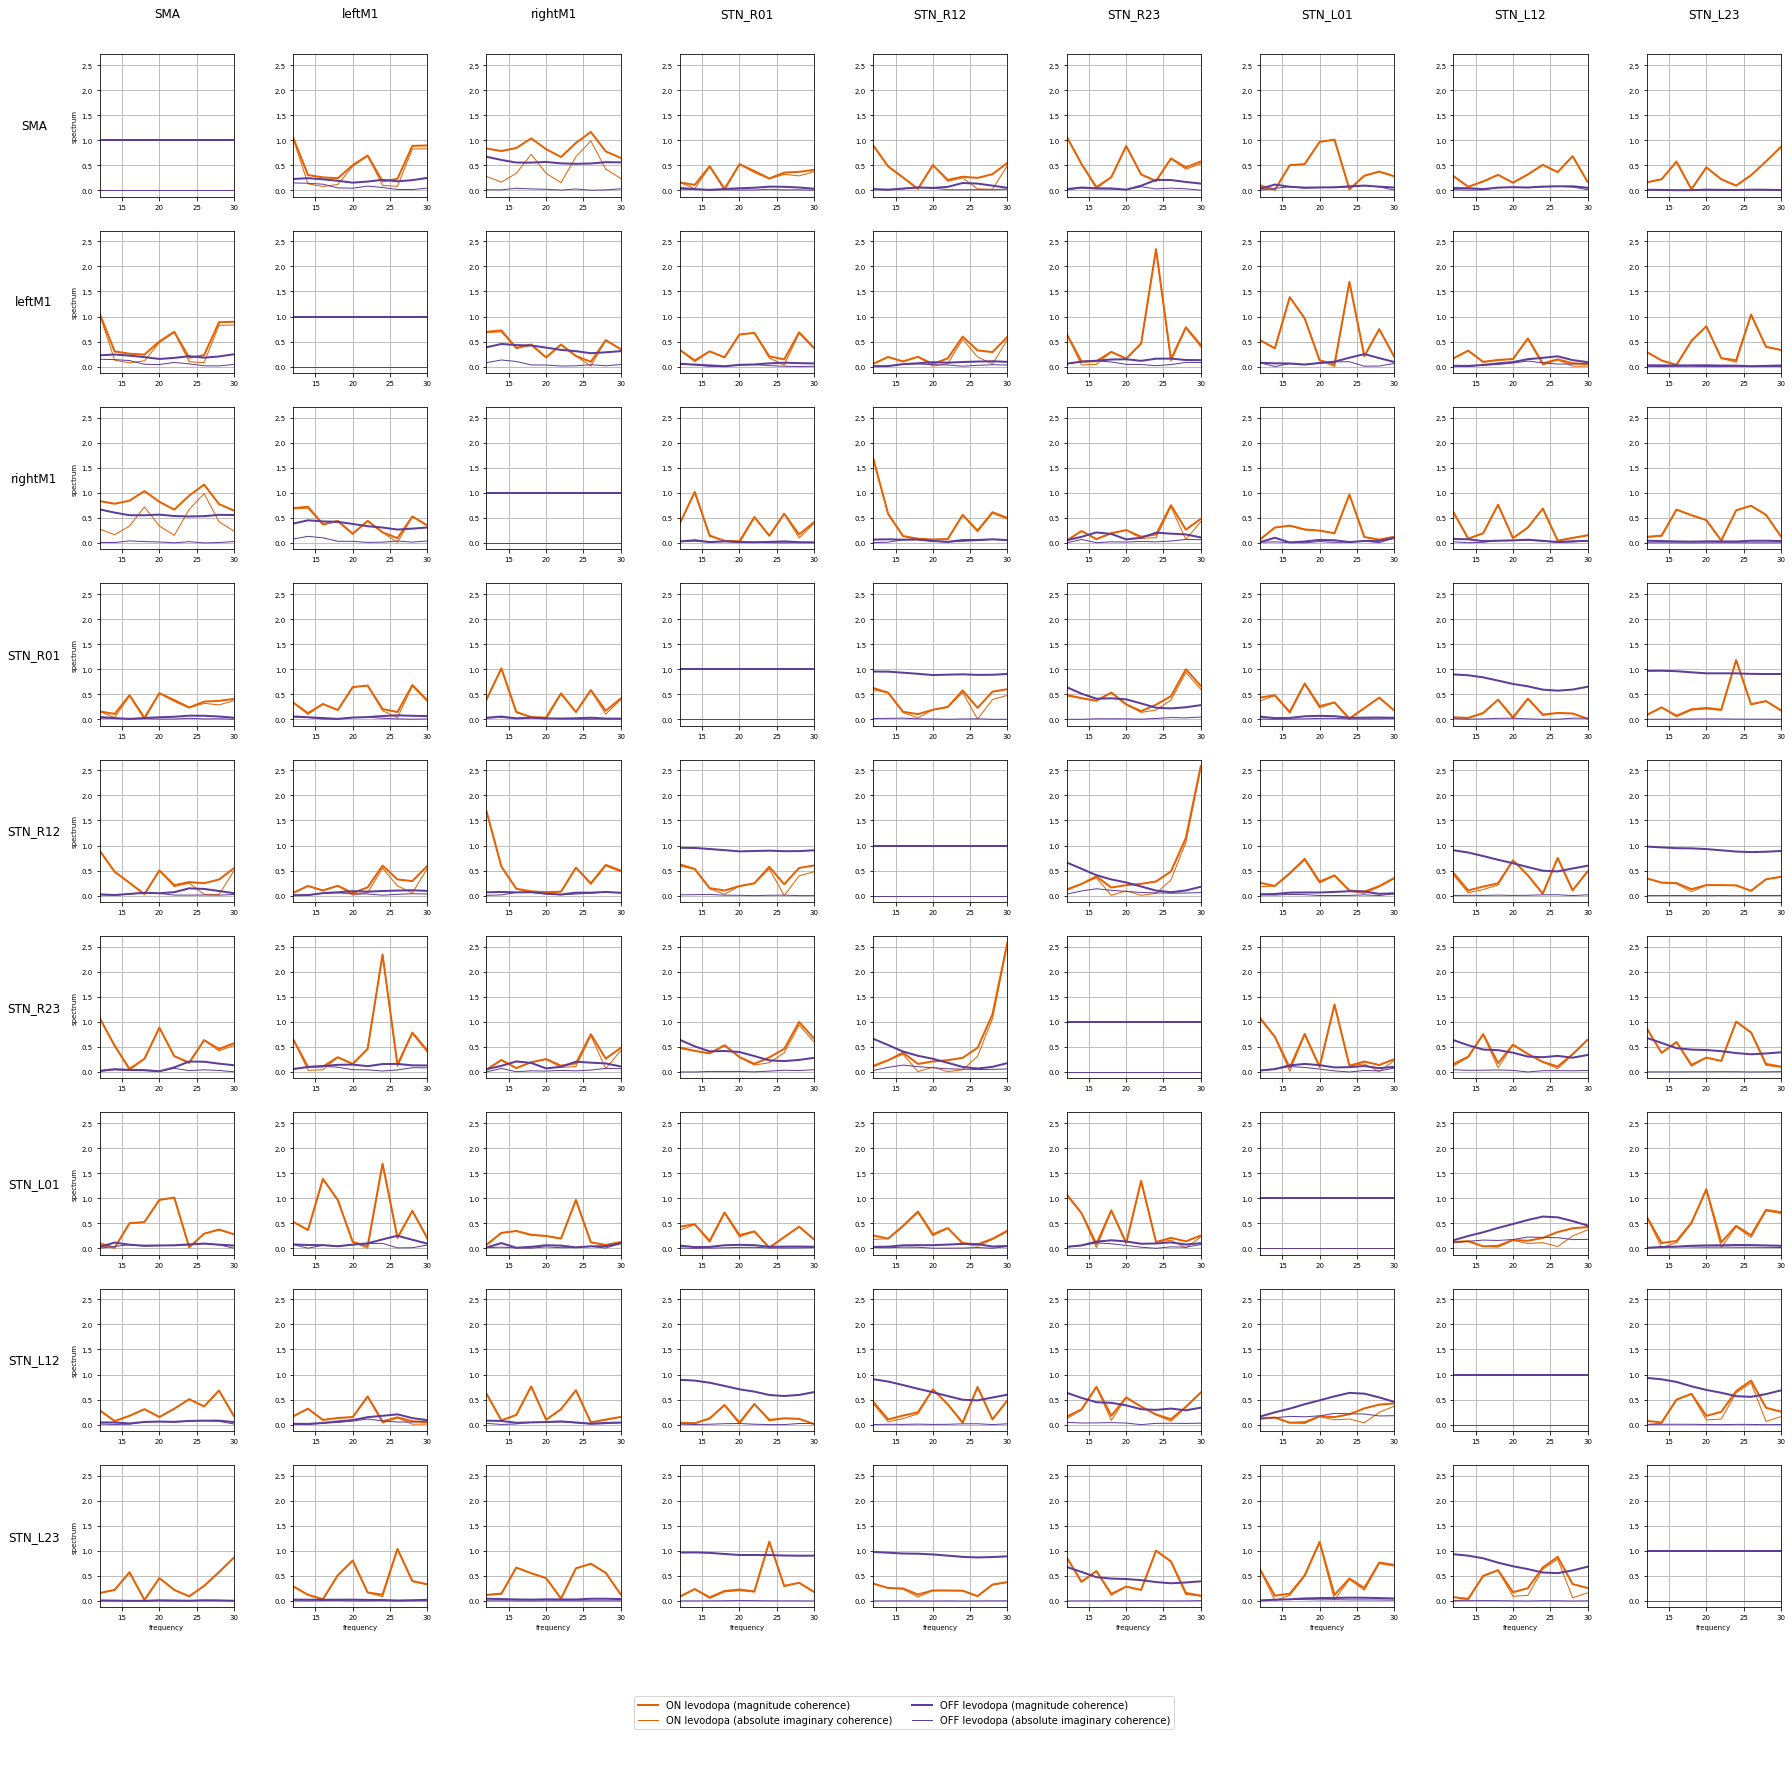

In [97]:
##################
# plot coherence #
##################
subj = 0
n_ch = 9 # plot only the first 9 channels

#on_f = on_f[subj][6:16] # beta range 12 - 30 Hz
#on_coherence = on_coherence[subj][6:16]
#off_f = off_f[subj][6:16]
#off_coherence = off_coherence[subj][6:16]


csd_fig = plt.figure(figsize=(25, 25))
csd_gs = mpl.gridspec.GridSpec(n_ch + 2, n_ch + 1, width_ratios=np.r_[0.1, [1]*n_ch], height_ratios = np.r_[0.1, [1]*(n_ch + 1)])
csd_axes = np.zeros([n_ch, n_ch], dtype=np.object)
csd_text_axes = np.zeros([n_ch, 2], dtype=np.object)
csd_lines = np.zeros((n_ch, n_ch, 4), dtype=np.object)
for i in range(n_ch):
    for j in range(n_ch):
        if (i == 0) & (j == 0):
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1])
        else:
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1], sharex=csd_axes[0,0], sharey=csd_axes[0,0])
        csd_axes[i,j].grid()
        csd_lines[i,j,0], = csd_axes[i,j].plot(on_f[subj][6:16], np.abs(on_coherence[subj][i,j][6:16]), ls='-', lw=2, color=color1) # warum ist Komma nötig um Warning zu unterdrücken?
        csd_lines[i,j,1], = csd_axes[i,j].plot(on_f[subj][6:16], np.abs(on_coherence[subj][i,j][6:16].imag), ls='-', lw=1, color=color1) # warum nicht absolut zum Quadrat?
        csd_lines[i,j,2], = csd_axes[i,j].plot(off_f[subj][6:16], np.abs(off_coherence[subj][i,j][6:16]), ls='-', lw=2, color=color2)
        csd_lines[i,j,3], = csd_axes[i,j].plot(off_f[subj][6:16], np.abs(off_coherence[subj][i,j][6:16].imag), ls='-', lw=1, color=color2)
        if i == 0:
            csd_text_axes[j,0] = csd_fig.add_subplot(csd_gs[i,j + 1], frameon=False)
            csd_text_axes[j,0].tick_params(**blind_ax)
            csd_text_axes[j,0].text(0.5,0.5, s=on_labels[subj][j], ha='center', va='center', fontsize=12)
        if i == n_ch - 1:
            csd_axes[i,j].set_xlabel('frequency')
        if j == 0:
            csd_axes[i,j].set_ylabel('spectrum')
            csd_text_axes[i,1] = csd_fig.add_subplot(csd_gs[i + 1,j], frameon=False)
            csd_text_axes[i,1].tick_params(**blind_ax)
            csd_text_axes[i,1].text(0.5,0.5, s=on_labels[subj][i], ha='center', va='center', fontsize=12)

csd_axes[0,0].set_xlim([12,30])
#csd_axes[0,0].set_ylim([0,1])

# add a dummy axis for the legend
csd_legend_ax = csd_fig.add_subplot(csd_gs[-1,:], frame_on=False)
csd_legend_ax.tick_params(**blind_ax)
csd_legend_ax.legend(
        (csd_lines[0,0,0], csd_lines[0,0,1], csd_lines[0,0,2], csd_lines[0,0,3]),
        ('ON levodopa (magnitude coherence)',
         'ON levodopa (absolute imaginary coherence)',
         'OFF levodopa (magnitude coherence)',
         'OFF levodopa (absolute imaginary coherence)'),
         loc='center', ncol=2)

csd_fig.tight_layout()
plt.savefig("/Users/moritzgerster/Documents/Promotion/Research_Updates/beta_coherence_mean.pdf")
#csd_fig.savefig('../../plots/subj1_csd_nperseg=srate.pdf')

#### Calculate coherence and ImCohy in range of 13-30 Hz

In [82]:
n_subj = 14
n_ch = len(on_labels[subj])
on_coh_beta = np.zeros([n_subj, n_ch, n_ch])
on_imcohy_beta = np.zeros([n_subj, n_ch, n_ch])
off_coh_beta = np.zeros([n_subj, n_ch, n_ch])
off_imcohy_beta = np.zeros([n_subj, n_ch, n_ch])

for subj in range(n_subj):
    for i in range(n_ch):
        for j in range(n_ch):

            on_coh_beta[subj, i,j] = np.mean(np.abs(on_coherence[subj][i,j][6:16]))
            on_imcohy_beta[subj, i,j] = np.mean(np.abs(on_coherence[subj][i,j][6:16].imag))

            off_coh_beta[subj, i,j] = np.mean(np.abs(off_coherence[subj][i,j][6:16]))
            off_imcohy_beta[subj, i,j] = np.mean(np.abs(off_coherence[subj][i,j][6:16].imag))

In [90]:
save_path = f'../../data/coherences/' 

info = {"labels": on_labels[0], "subjects": np.arange(14), "csd_average": "mean"}

np.save(save_path + "info", info, allow_pickle=True)
np.save(save_path + "on_coh_beta", on_coh_beta, allow_pickle=True)
np.save(save_path + "on_imcohy_beta", on_imcohy_beta, allow_pickle=True)
np.save(save_path + "off_coh_beta", off_coh_beta, allow_pickle=True)
np.save(save_path + "off_imcohy_beta", off_imcohy_beta, allow_pickle=True)

#### Create pandas data framen_subj

In [58]:
columns = ["subject", "task", "condition", "type", "channel", "coh_beta", "imcohy_beta", "exponent", "offset", "aperiodic_mode", "beta_power"]

In [89]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
df

,col1,col2
0,1,3
1,2,4
